### 1.  Khai báo thư viện cần thiết

In [28]:
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
from skimage.feature import hog
from tqdm import tqdm
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import joblib
import threading

### 2. Tiền xử lý dữ liệu, hiển thị các thông tin về bộ dữ liệu bằng các biểu đồ trực quan

In [2]:
def read_img(path,gray=True,rgb=False):
    if gray:
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(path)
    img=cv2.resize(img,(128,128),interpolation=cv2.INTER_AREA)
    if rgb:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

def show_img(img,gray=False):
    if gray:
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)
    plt.axis('off')
    plt.show()

In [3]:
folder_name="data"
folder_name_data=["train"]

In [4]:
dict_count={}
file_anh_train=[]
file_anh_test=[]
for fnd in folder_name_data:
    list_file = os.listdir(folder_name +"/"+ fnd)
    for i in list_file:
        list_file_i=len(os.listdir(folder_name +"/"+ fnd+"/"+i))
        if fnd == "train":
            for j in os.listdir(folder_name +"/"+ fnd+"/"+i):
                file_anh_train.append(folder_name +"/"+ fnd+"/"+i+"/"+j)
        else:
            for j in os.listdir(folder_name +"/"+ fnd+"/"+i):
                file_anh_test.append(folder_name +"/"+ fnd+"/"+i+"/"+j)
        if i in dict_count:
            dict_count[i]+=list_file_i
        else:
            dict_count[i]=list_file_i

In [5]:
dict_count.values()

dict_values([600, 600, 600, 600, 600])

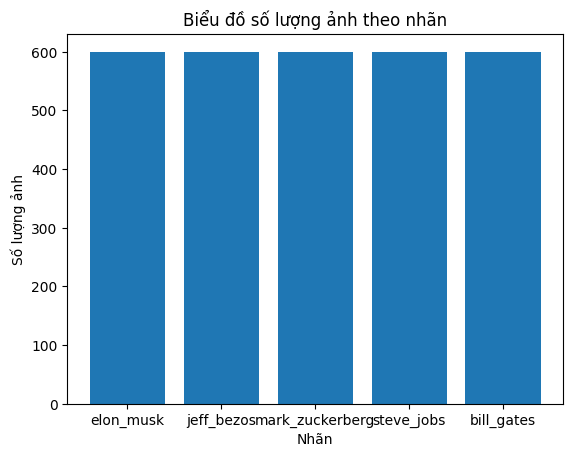

In [6]:
plt.bar(dict_count.keys(), dict_count.values())
plt.xlabel('Nhãn')
plt.ylabel('Số lượng ảnh')
plt.title('Biểu đồ số lượng ảnh theo nhãn')
plt.show()

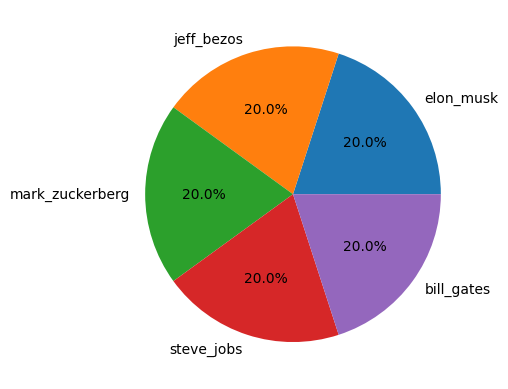

In [7]:
plt.pie(dict_count.values(),labels=dict_count.keys(),autopct='%1.1f%%')
plt.show()

In [8]:
file_img_path=file_anh_train+file_anh_test
file_img_path[:5]

['data/train/elon_musk/23c27c8a-2ae2-4dc7-a897-e97ae08c0fde.jpg',
 'data/train/elon_musk/4ef80041-89c4-4759-b48a-1855e7f5a20d.jpg',
 'data/train/elon_musk/b3b16d69-6438-4693-a550-99fb7f92714f.jpg',
 'data/train/elon_musk/7629cb63-f30e-4e2f-93fa-0ba3b890792b.jpg',
 'data/train/elon_musk/81447f1f-bfce-4848-bf56-42133b54d436.jpg']

### 3. Chia dữ liệu thành 2 phần: Train/Test với tỉ lệ tùy ý

In [10]:
train,test=train_test_split(file_img_path,test_size=0.2,random_state=42)

In [11]:
len(train)

2400

In [12]:
len(test)

600

In [13]:
la={
    'bill_gates': 0,
    'elon_musk': 1,
    'jeff_bezos': 2,
    'mark_zuckerberg': 3,
    'steve_jobs': 4
}

### 4. Trích xuất đặc trưng: HOG (Histogram of Oriented Gradient)

In [14]:
def extract_features_hog(dataset, labels = la):
    hog_imgs = []
    features_imgs = []
    labels_hog = []
    path_imgs = []
    for i in tqdm(dataset, desc='Trích xuất đặc trưng HOG'):
        label_name = os.path.basename(os.path.dirname(i))
        label_index = la.get(label_name, -1)
        labels_hog.append(label_index)
        
        image = cv2.imread(i)
        image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        cell_size = (8, 8) 
        block_size = (2, 2)  
        nbins = 9  

        features, hog_image = hog(gray, orientations=nbins, pixels_per_cell=cell_size, cells_per_block=block_size, visualize=True, block_norm='L2')
        hog_imgs.append(hog_image)
        features_imgs.append(features)
        path_imgs.append(i)
    return hog_imgs, features_imgs, labels_hog, path_imgs


In [15]:

def extract_features_hog_thread(dataset, result):
    hog_imgs, features_imgs, labels_hog, path_imgs = extract_features_hog(dataset)
    result.append((hog_imgs, features_imgs, labels_hog, path_imgs))

def run_threading_extract_hog(dataset, num_thread=12):
    datasets = np.array_split(dataset, num_thread)
    threads = []
    results = []
    
    for i in range(num_thread):
        thread = threading.Thread(target=extract_features_hog_thread, args=(datasets[i], results))
        thread.start()
        threads.append(thread)
    
    for thread in threads:
        thread.join()

    hog_imgs = []
    features_imgs = []
    labels_hog = []
    path_imgs = []
    
    for result in results:
        hog_imgs.extend(result[0])
        features_imgs.extend(result[1])
        labels_hog.extend(result[2])
        path_imgs.extend(result[3])
    
    return hog_imgs, features_imgs, labels_hog, path_imgs


In [16]:
X_train_hog, X_train_features, y_train_labels,train_path_imgs = run_threading_extract_hog(train)

Trích xuất đặc trưng HOG:   0%|          | 0/200 [00:00<?, ?it/s]






























































































Trích xuất đặc trưng HOG:   0%|          | 1/200 [00:00<01:27,  2.28it/s]















































Trích xuất đặc trưng HOG:   1%|          | 2/200 [00:00<01:20,  2.47it/s]




































































Trích xuất đặc trưng HOG:   2%|▏         | 3/200 [00:01<01:20,  2.45it/s]
























Trích xuất đặc trưng HOG:   2%|▏         | 4/200 [00:01<01:10,  2.77it/s]
















































Trích xuất đặc trưng HOG:   2%|▎         | 5/200 [00:01<01:13,  2.64it/s]






























































Trích xuất đặc trưng HOG:   3%|▎         | 6/200 [00:02<01:25,  2.28it/s]





































































Trích xuất đặc trưng HOG:   4%|▎         | 7/200 [00:02<01:23,  2.30it/s]






















































Trích xuất đặc trưng HOG:   4%|▍         | 8

In [17]:
X_test_hog, X_test_features, y_test_labels,test_path_imgs = run_threading_extract_hog(test)

Trích xuất đặc trưng HOG:   0%|          | 0/50 [00:00<?, ?it/s]
























































Trích xuất đặc trưng HOG:   2%|▏         | 1/50 [00:00<00:37,  1.31it/s]







































































Trích xuất đặc trưng HOG:   4%|▍         | 2/50 [00:01<00:34,  1.38it/s]





































































Trích xuất đặc trưng HOG:   6%|▌         | 3/50 [00:02<00:32,  1.43it/s]




































































Trích xuất đặc trưng HOG:   8%|▊         | 4/50 [00:02<00:33,  1.37it/s]










































Trích xuất đặc trưng HOG:  10%|█         | 5/50 [00:03<00:30,  1.49it/s]






















































Trích xuất đặc trưng HOG:  12%|█▏        | 6/50 [00:04<00:31,  1.38it/s]

























































Trích xuất đặc trưng HOG:  14%|█▍        | 7/50 [00:05<00:33,  1.29it/s]









In [18]:
def get_key_from_value(dictionary, target_value):
    for key, value in dictionary.items():
        if value == target_value:
            return key
    return None  

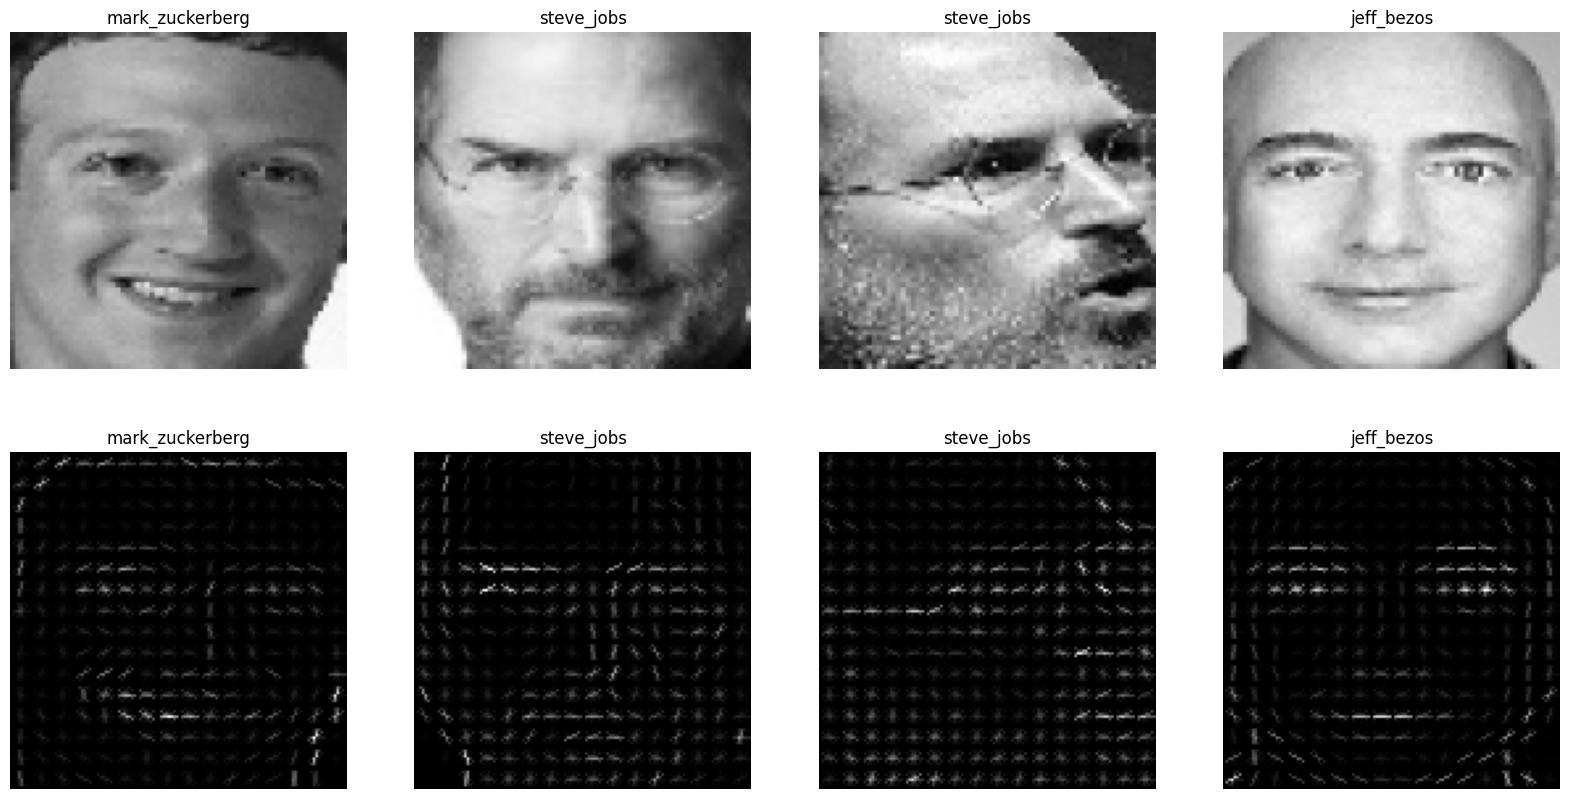

In [19]:
column = 4
random_choice = random.sample(range(len(X_train_hog)), column)
fig, axs = plt.subplots(2, column, figsize=(20, 10))
for i in range(column):
    img = read_img(train_path_imgs[random_choice[i]])
    axs[0,i].imshow(img,cmap='gray')
    axs[0,i].set_title(get_key_from_value(la,y_train_labels[random_choice[i]]))
    axs[0,i].axis('off')
    axs[1,i].imshow(X_train_hog[random_choice[i]],cmap='gray')
    axs[1,i].set_title(get_key_from_value(la,y_train_labels[random_choice[i]]))
    axs[1,i].axis('off')
plt.show()

### 5. Trích xuất đặc trưng SIFT

In [20]:

def extract_sift_features(dataset):
    sift = cv2.SIFT_create()
    sift_features = []
    kp_list = []
    labels = []
    for i in tqdm(dataset):
        label_name = os.path.basename(os.path.dirname(i))
        label_index = la.get(label_name, -1)
        labels.append(label_index)
        
        image = read_img(i)
        kp, des = sift.detectAndCompute(image, None)
        sift_features.append(des)
        kp_list.append(kp)
    return kp_list, sift_features, labels

def Bag_of_Visual_Words(dataset, num_clusters=60):
    bovw_features = []
    kp_list, sift_features, labels = extract_sift_features(dataset)
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(np.vstack(sift_features))
    if not os.path.exists('kmeans.pkl'):
        joblib.dump(kmeans, 'kmeans.pkl')
    for features in tqdm(sift_features):
        histogram = np.zeros(num_clusters)
        if features is not None:
            clusters = kmeans.predict(features)
            for cluster in clusters:
                histogram[cluster] += 1
        bovw_features.append(histogram)
    return np.array(bovw_features) / 255.0, labels

def build_model(dataset):
    X_features, y_labels = Bag_of_Visual_Words(dataset)
    return X_features, y_labels


100%|██████████| 1/1 [00:00<00:00, 59.22it/s]


[0]


100%|██████████| 1/1 [00:00<00:00, 402.25it/s]


[3]


100%|██████████| 1/1 [00:00<00:00, 319.91it/s]


[3]


100%|██████████| 1/1 [00:00<00:00, 408.80it/s]


[2]


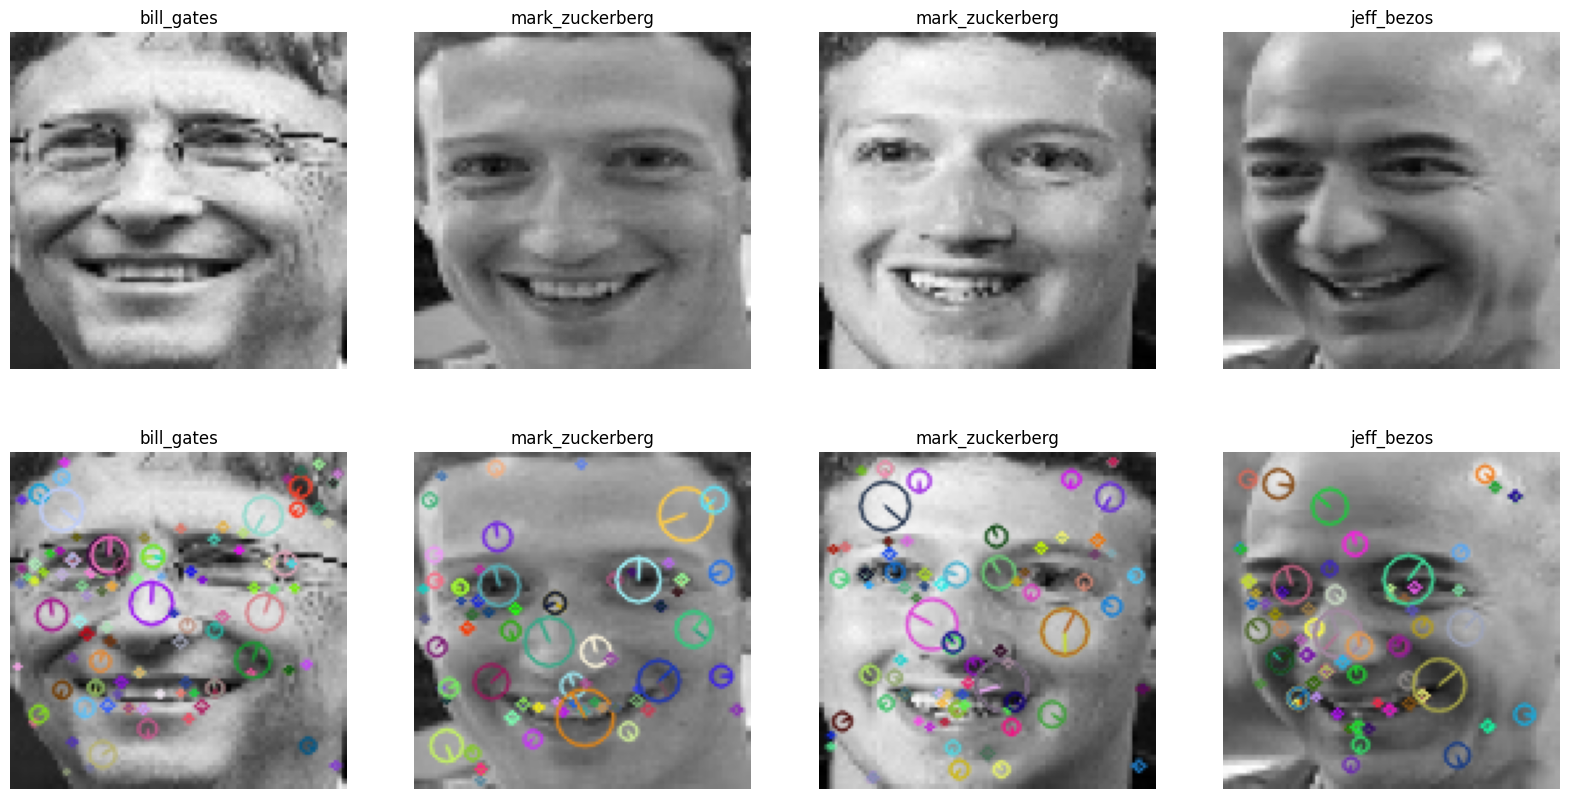

In [21]:
column = 4
random_choice = random.sample(range(len(train)), column)
fig, axs = plt.subplots(2, column, figsize=(20, 10))
for i in range(column):
    img = read_img(train[random_choice[i]])
    kp_list,sift_features, labels = extract_sift_features([train[random_choice[i]]])
    print(labels)
    axs[0,i].imshow(img,cmap='gray')
    axs[0,i].set_title(get_key_from_value(la,labels[0]))
    axs[0,i].axis('off')
    axs[1,i].imshow(cv2.drawKeypoints(img, kp_list[0], img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS),cmap='gray')
    axs[1,i].set_title(get_key_from_value(la,labels[0]))
    axs[1,i].axis('off')
plt.show()

In [22]:
X_train_sift_features, y_train_sift = build_model(train)
X_test_sift_features, y_test_sift = build_model(test)

100%|██████████| 2400/2400 [00:06<00:00, 382.59it/s]
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 600/600 [00:03<00:00, 183.70it/s]
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 600/600 [00:00<00:00, 1812.94it/s]


### 6. Huấn luyện bằng các mô hình SVM với đặc trưng HOG, trực quan hoá 

In [54]:
model_hog = svm.SVC()
num_epochs =1
for _ in tqdm(range(num_epochs), desc="Training"):
    model_hog.fit(X_train_features, y_train_labels)

joblib.dump(model_hog, 'model_svm_hog.pkl')

Training: 100%|██████████| 1/1 [00:27<00:00, 27.11s/it]


['model_svm_hog.pkl']

In [55]:
y_predictions = model_hog.predict(X_test_features)

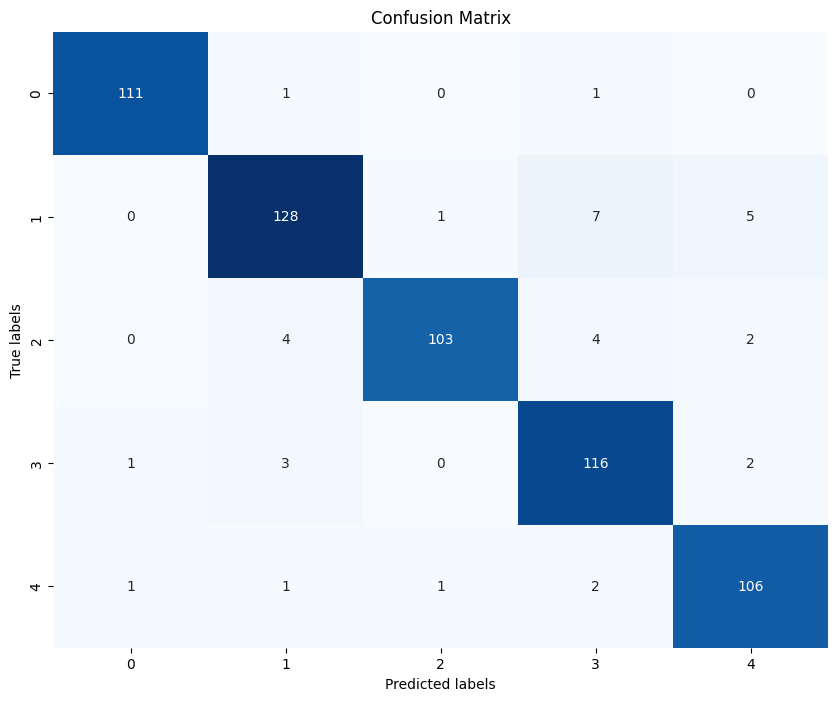

In [56]:
cm = confusion_matrix(y_test_labels, y_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

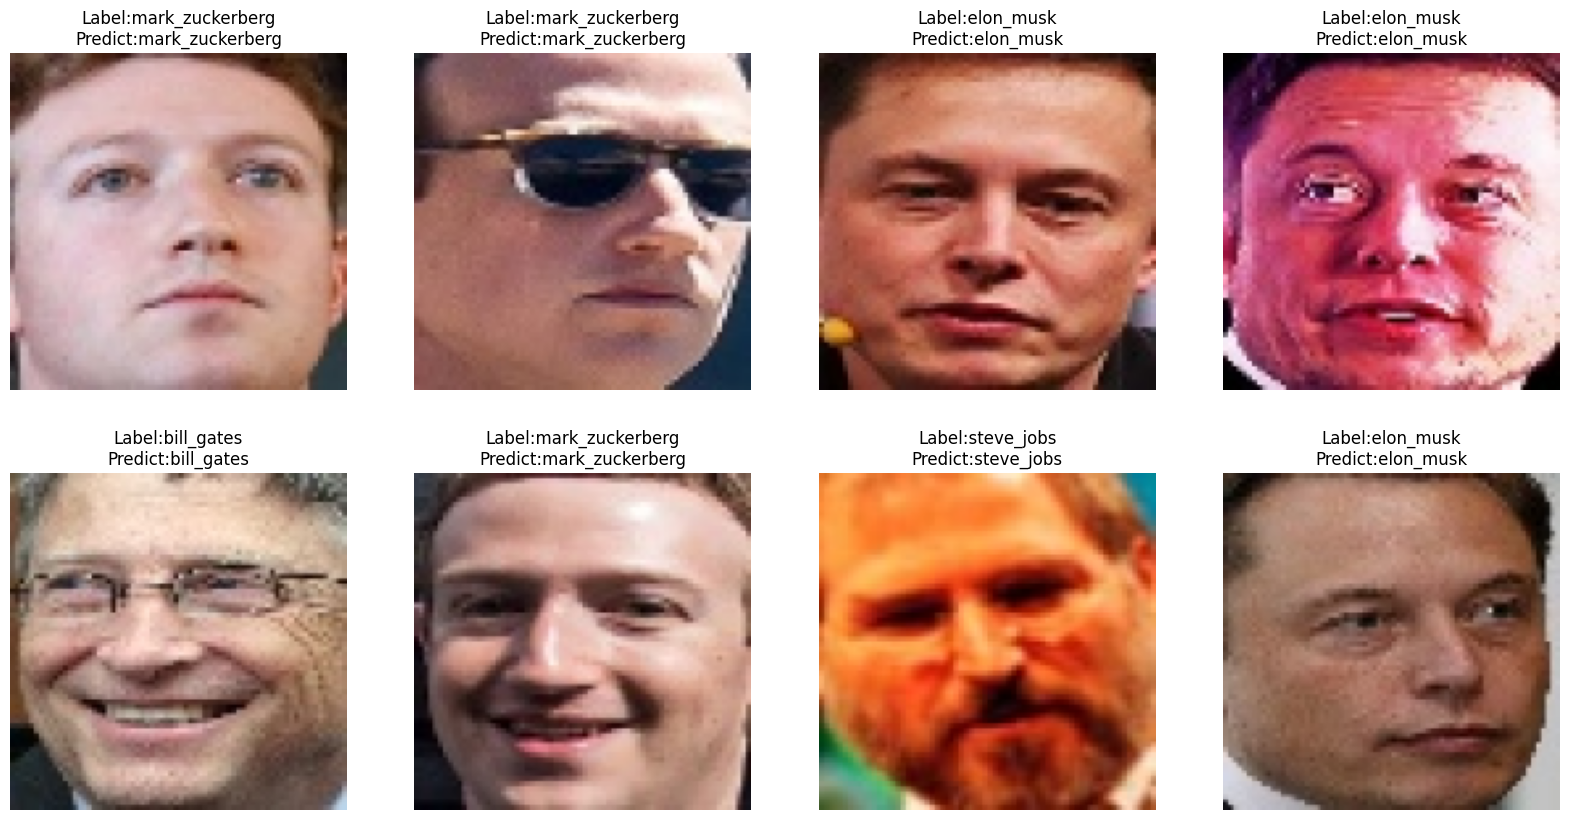

In [57]:
column = 4
row = 2
fig, axs = plt.subplots(2, column, figsize=(20, 10))
for i in range(row):
    random_choice = random.sample(range(len(X_test_hog)), column)
    for j in range(column):
        img = read_img(test_path_imgs[random_choice[j]], False, True)
        axs[i,j].imshow(img)
        axs[i,j].set_title("Label:"+get_key_from_value(la,y_test_labels[random_choice[j]])+"\nPredict:"+get_key_from_value(la,y_predictions[random_choice[j]]))
        axs[i,j].axis('off')
plt.show()

### 7. Huấn luyện bằng các mô hình SVM với đặc trưng SIFT, trực quan hoá


In [59]:
model_sift = svm.SVC()
num_epochs =1

for _ in tqdm(range(num_epochs), desc="Training"):
    model_sift.fit(X_train_sift_features, y_train_sift)
    
joblib.dump(model_sift, 'model_svm_sift.pkl')

Training: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


['model_svm_sift.pkl']

In [60]:
y_predictions_sift = model_sift.predict(X_test_sift_features)

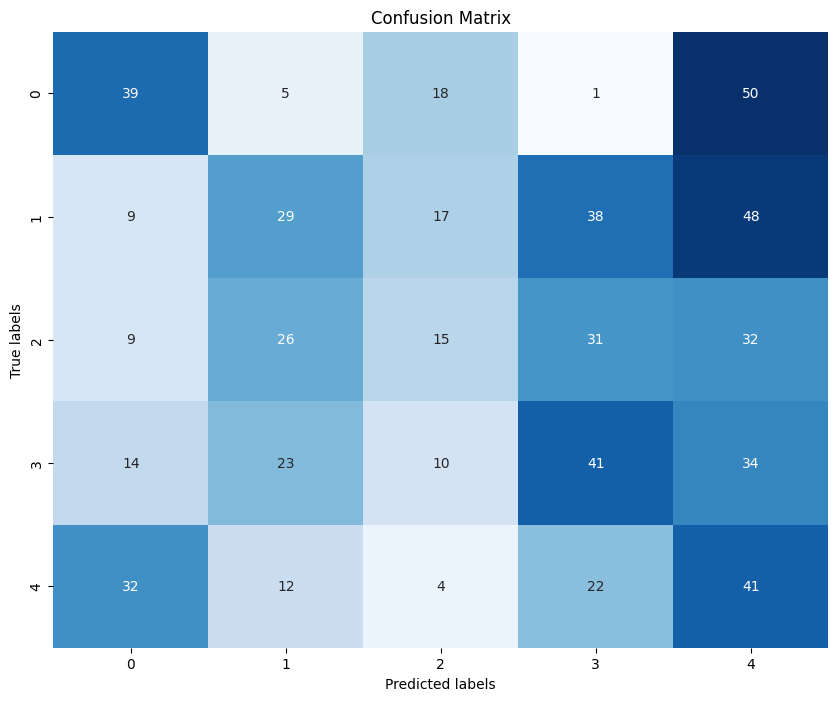

In [61]:
cm = confusion_matrix(y_test_sift, y_predictions_sift)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

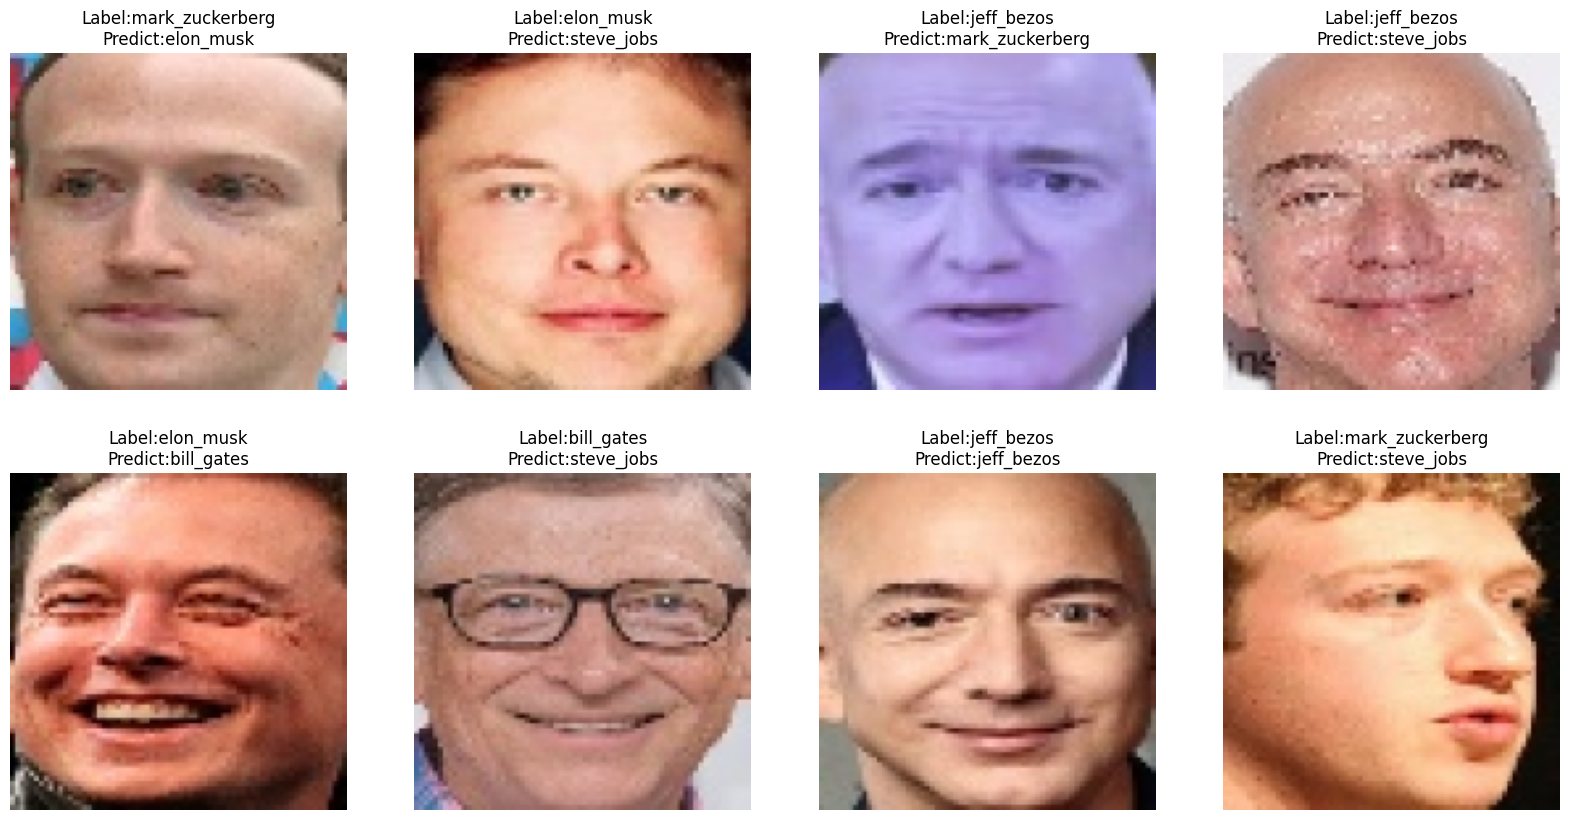

In [62]:
column = 4
row = 2
fig, axs = plt.subplots(2, column, figsize=(20, 10))
for i in range(row):
    random_choice = random.sample(range(len(X_test_sift_features)), column)
    for j in range(column):
        img = read_img(test[random_choice[j]],False,True)
        axs[i,j].imshow(img)
        axs[i,j].set_title("Label:"+get_key_from_value(la,y_test_sift[random_choice[j]])+"\nPredict:"+get_key_from_value(la,y_predictions_sift[random_choice[j]]))

        axs[i,j].axis('off')
plt.show()

### 8. Huấn luyện bằng các mô hình RandomForest với đặc trưng HOG, trực quan hoá 

In [63]:
rf_classifier_hog = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_hog.fit(X_train_features, y_train_labels)

joblib.dump(rf_classifier_hog, 'model_rf_hog.pkl')

['model_rf_hog.pkl']

In [64]:
predict_hog = rf_classifier_hog.predict(X_test_features)

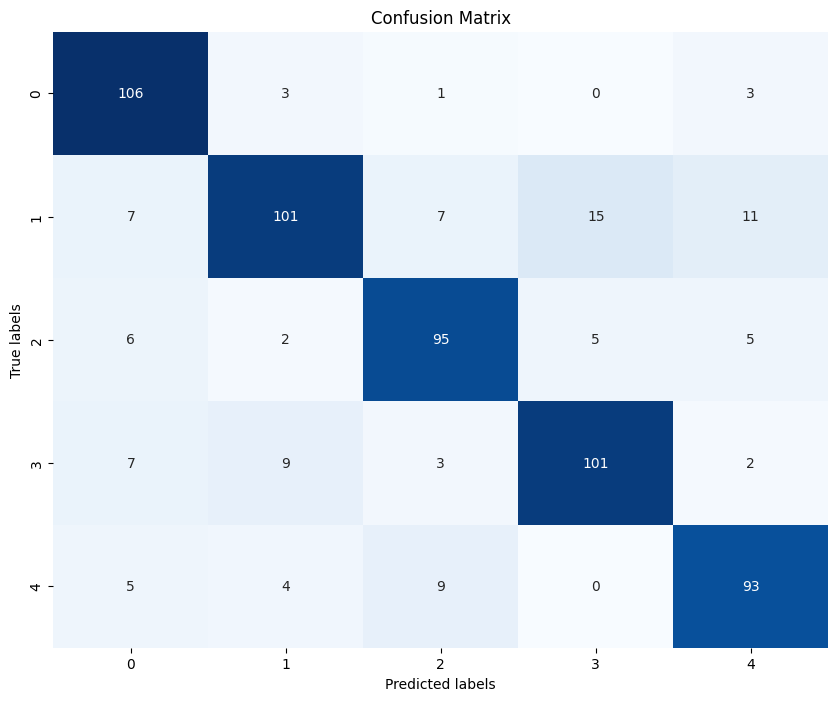

In [65]:
cm = confusion_matrix(y_test_labels, predict_hog)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

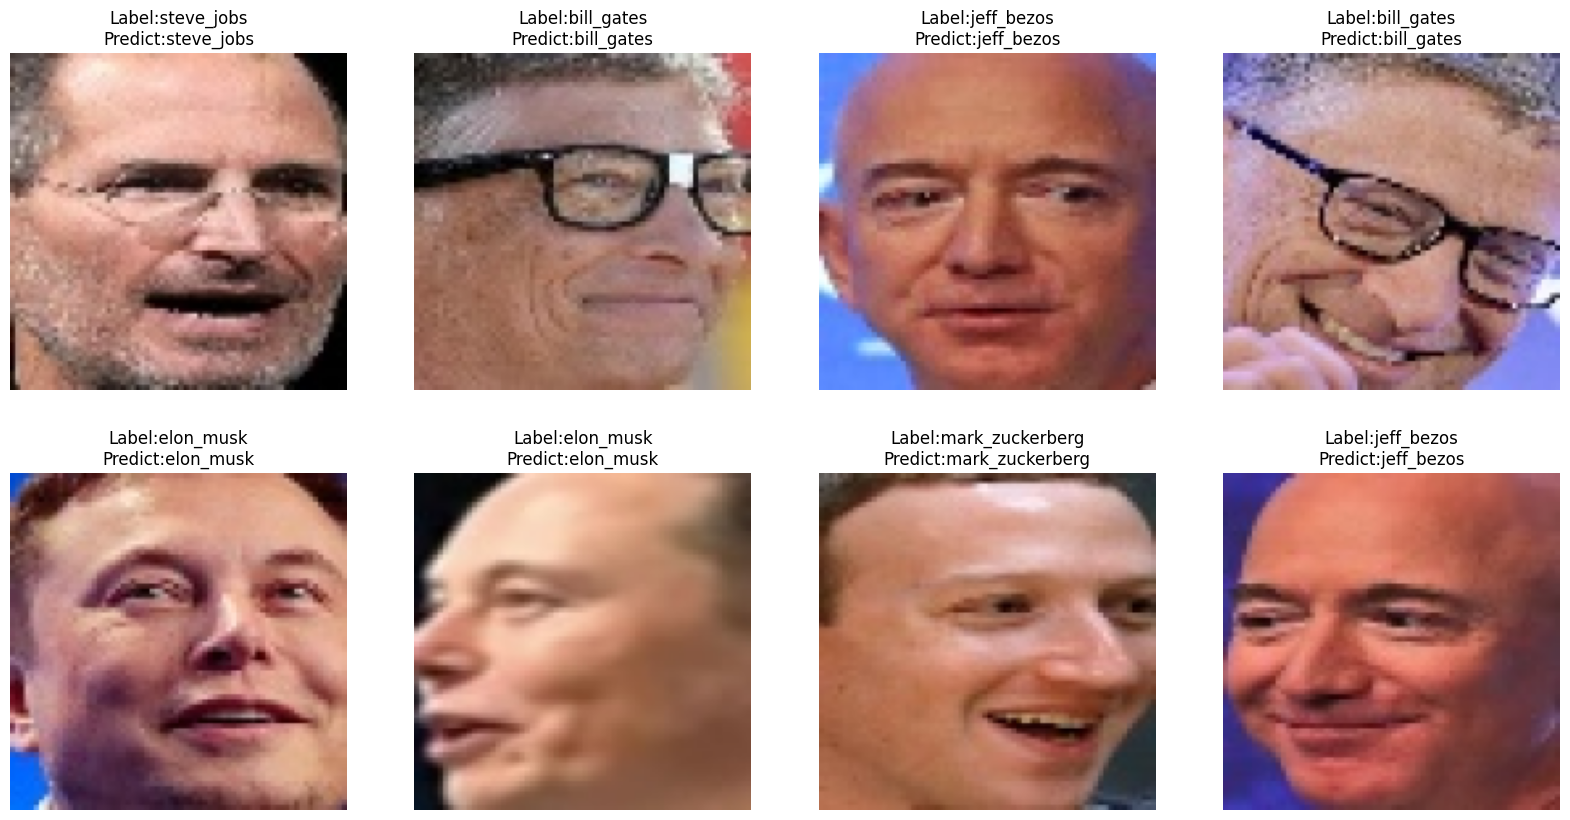

In [66]:
column = 4
row = 2
fig, axs = plt.subplots(2, column, figsize=(20, 10))
for i in range(row):
    random_choice = random.sample(range(len(X_test_hog)), column)
    for j in range(column):
        img = read_img(test_path_imgs[random_choice[j]], False, True)
        axs[i,j].imshow(img)
        axs[i,j].set_title("Label:"+get_key_from_value(la,y_test_labels[random_choice[j]])+"\nPredict:"+get_key_from_value(la,predict_hog[random_choice[j]]))
        axs[i,j].axis('off')
plt.show()

### 9. Huấn luyện bằng các mô hình RandomForest với đặc trưng SIFT, trực quan hoá


In [67]:
rf_classifier_sift = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_sift.fit(X_train_sift_features, y_train_sift)

joblib.dump(rf_classifier_sift, 'model_rf_sift.pkl')

['model_rf_sift.pkl']

In [68]:
predict_sift = rf_classifier_sift.predict(X_test_sift_features)

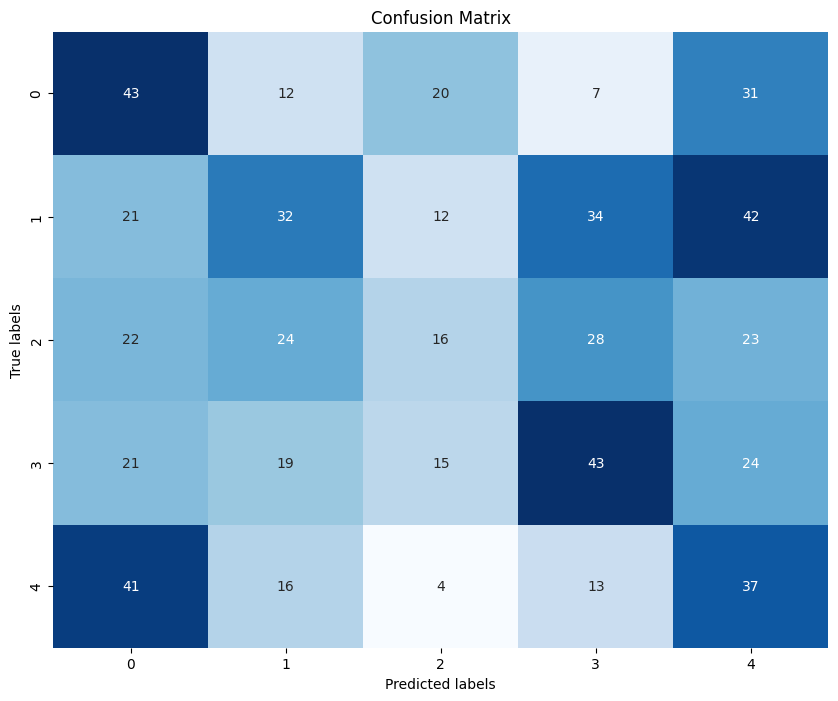

In [69]:
cm = confusion_matrix(y_test_sift, predict_sift)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

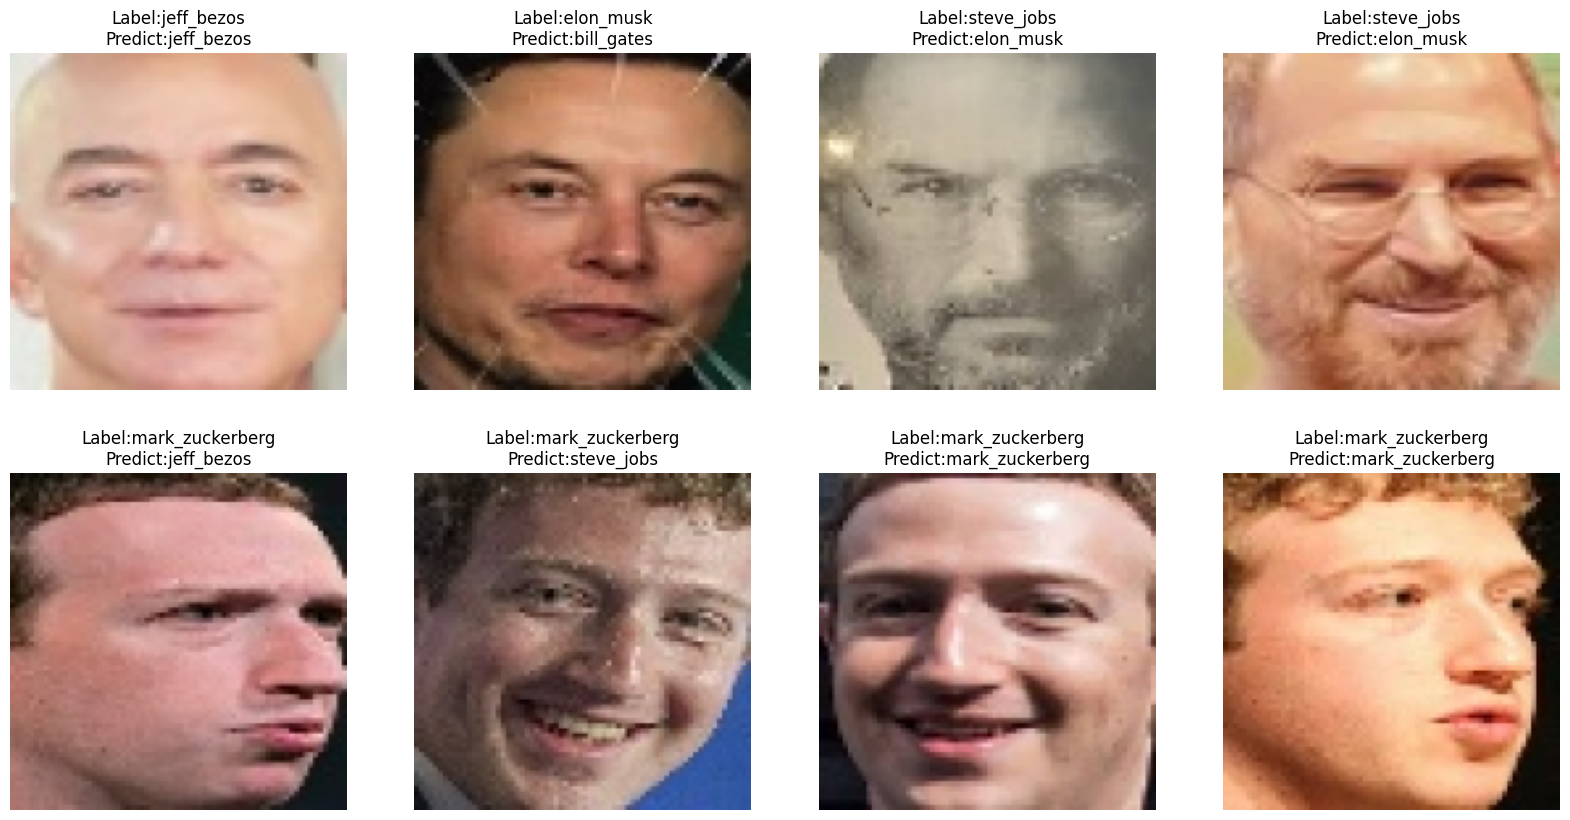

In [70]:
column = 4
row = 2
fig, axs = plt.subplots(2, column, figsize=(20, 10))
for i in range(row):
    random_choice = random.sample(range(len(X_test_sift_features)), column)
    for j in range(column):
        img = read_img(test[random_choice[j]],False,True)
        axs[i,j].imshow(img)
        axs[i,j].set_title("Label:"+get_key_from_value(la,y_test_sift[random_choice[j]])+"\nPredict:"+get_key_from_value(la,predict_sift[random_choice[j]]))

        axs[i,j].axis('off')
plt.show()

### 10. Đánh giá kết quả của các mô hình

HOG và SVM

In [71]:
print(classification_report(y_test_labels, y_predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       113
           1       0.93      0.91      0.92       141
           2       0.98      0.91      0.94       113
           3       0.89      0.95      0.92       122
           4       0.92      0.95      0.94       111

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



SIFT và SVM

In [72]:
print(classification_report(y_test_sift, y_predictions_sift))

              precision    recall  f1-score   support

           0       0.38      0.35      0.36       113
           1       0.31      0.21      0.25       141
           2       0.23      0.13      0.17       113
           3       0.31      0.34      0.32       122
           4       0.20      0.37      0.26       111

    accuracy                           0.28       600
   macro avg       0.29      0.28      0.27       600
weighted avg       0.29      0.28      0.27       600



HOG và RandomForest

In [73]:
print(classification_report(y_test_labels, predict_hog))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       113
           1       0.85      0.72      0.78       141
           2       0.83      0.84      0.83       113
           3       0.83      0.83      0.83       122
           4       0.82      0.84      0.83       111

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600



SIFT và RandomForest

In [74]:
print(classification_report(y_test_sift, predict_sift))

              precision    recall  f1-score   support

           0       0.29      0.38      0.33       113
           1       0.31      0.23      0.26       141
           2       0.24      0.14      0.18       113
           3       0.34      0.35      0.35       122
           4       0.24      0.33      0.28       111

    accuracy                           0.28       600
   macro avg       0.28      0.29      0.28       600
weighted avg       0.29      0.28      0.28       600



### 11. Dự đoán từ 1 ảnh vào bất kỳ, cho biết người đó là ai?

In [75]:
model_svm_hog=joblib.load('model_svm_hog.pkl')
model_svm_sift=joblib.load('model_svm_sift.pkl')
kmeans=joblib.load('kmeans.pkl')
model_rf_hog=joblib.load('model_rf_hog.pkl')
model_rf_sift=joblib.load('model_rf_sift.pkl')


In [100]:
def predict_img_hog(model,img_path):
    image = read_img(img_path)
    cell_size = (8, 8) 
    block_size = (2, 2)  
    nbins = 9  
    features,hog_image = hog(image, orientations=nbins, pixels_per_cell=cell_size,cells_per_block=block_size,visualize=True,block_norm='L2')
    return get_key_from_value(la,model_svm_hog.predict([features])[0]), get_key_from_value(la,model_rf_hog.predict([features])[0])

def predict_img_sift(model,img_path,k=60):
    sift =cv2.SIFT_create()
    image = read_img(img_path)
    kp, des = sift.detectAndCompute(image, None)
    histogram = np.zeros(k)
    if des is not None:
        clusters = kmeans.predict(des)
        for cluster in clusters:
            histogram[cluster] += 1
    bovw_features=(np.array(histogram)/255.0).reshape(1,-1)
    return get_key_from_value(la,model_svm_sift.predict(bovw_features)[0]), get_key_from_value(la,model_rf_sift.predict(bovw_features)[0])

In [98]:
list_img_validation_bill_gates= glob.glob('data/valid/bill_gates/*.jpg')
list_img_validation_elon_musk= glob.glob('data/valid/elon_musk/*.jpg')
list_img_validation_mark_zuckerberg= glob.glob('data/valid/mark_zuckerberg/*.jpg')
list_img_validation_jeff_bezos= glob.glob('data/valid/jeff_bezos/*.jpg')
list_img_validation_steve_jobs= glob.glob('data/valid/steve_jobs/*.jpg')

In [105]:
list_img_validation=list_img_validation_mark_zuckerberg+list_img_validation_bill_gates + list_img_validation_elon_musk + list_img_validation_jeff_bezos + list_img_validation_steve_jobs
# suffe list
random.shuffle(list_img_validation)

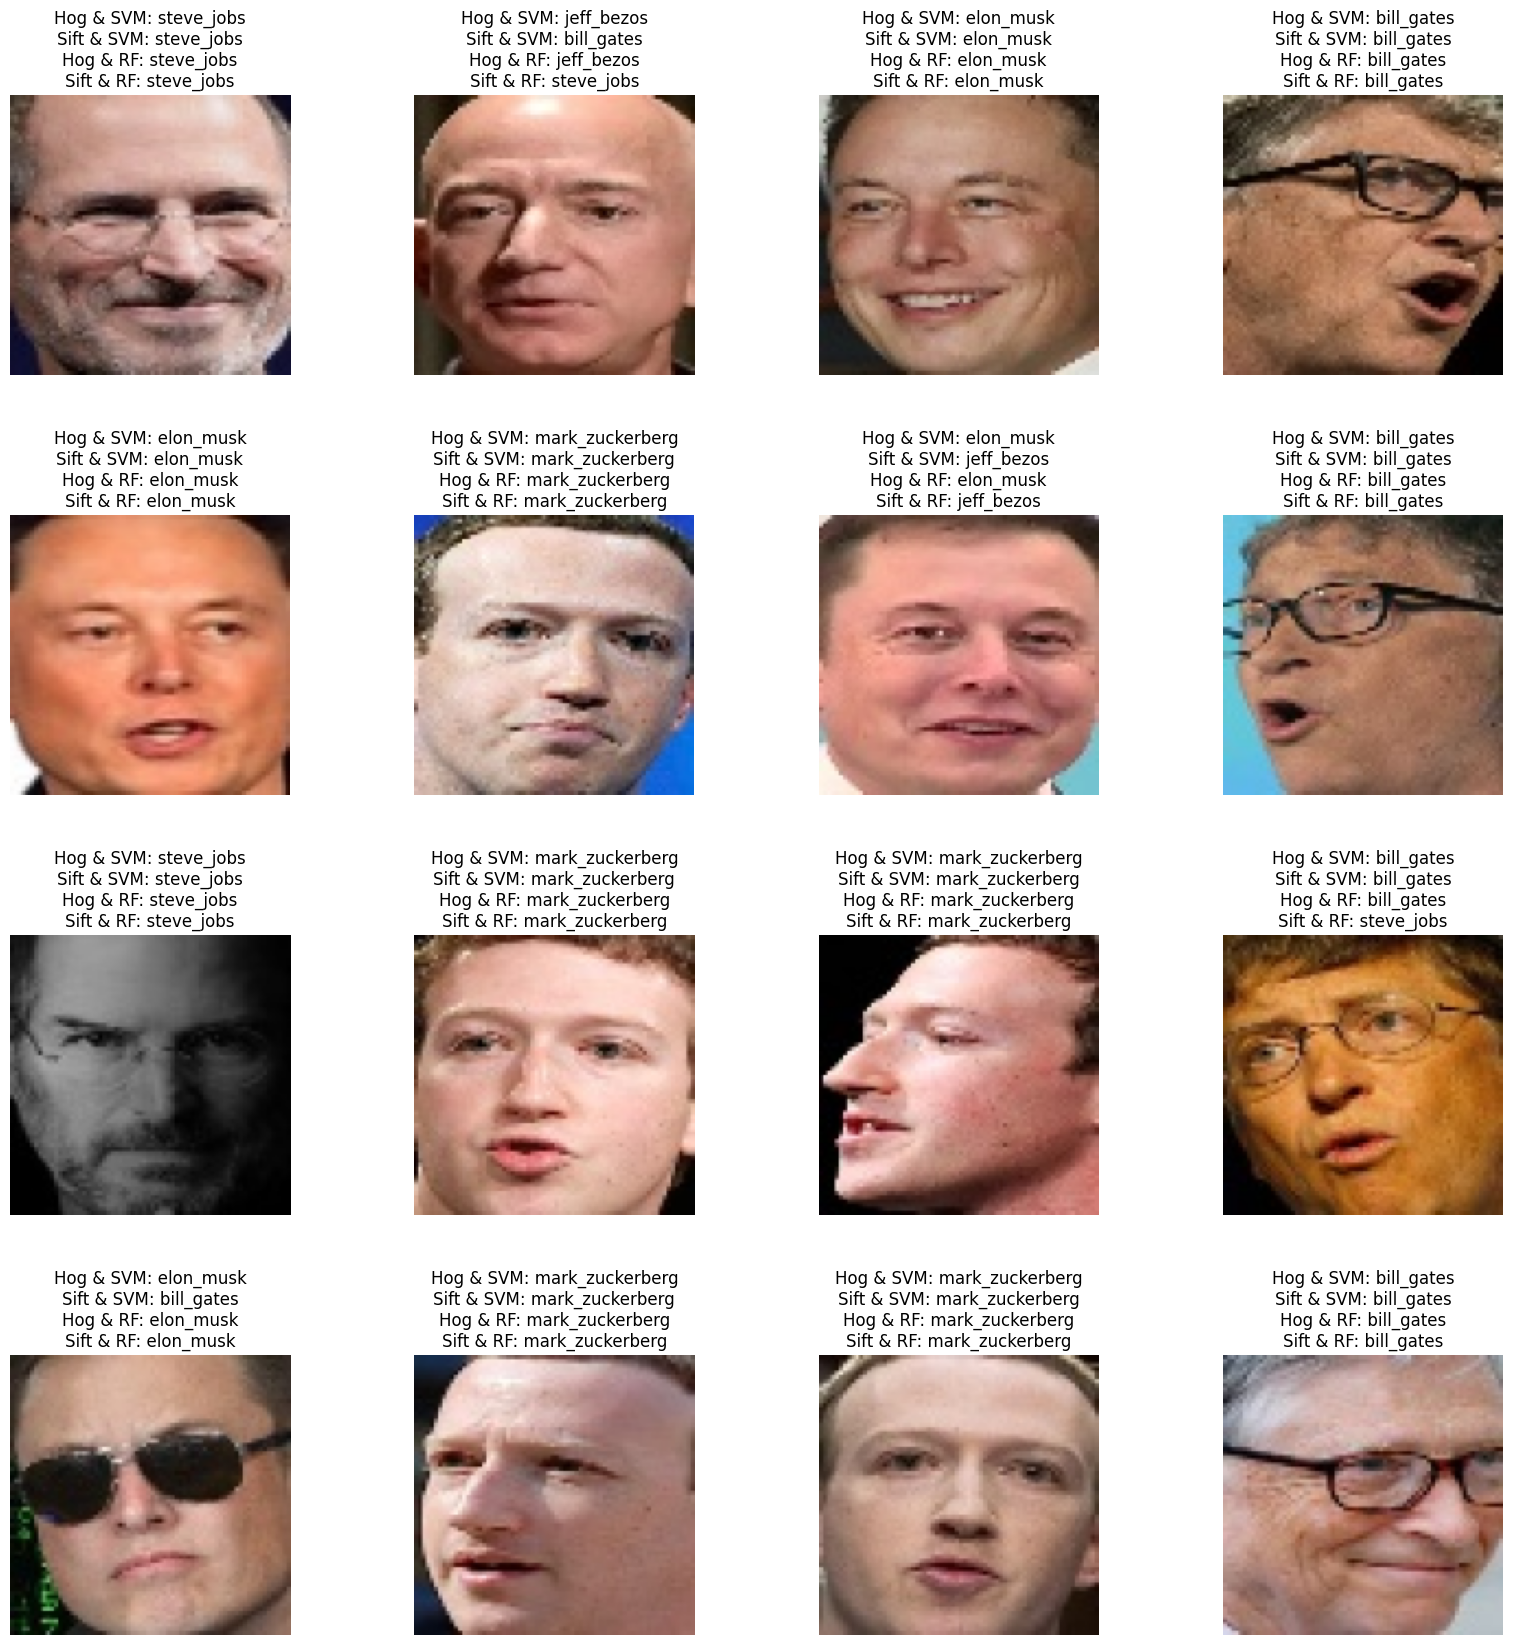

In [107]:
column = 4
row = 4
fig, axs = plt.subplots(row, column, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5) 

for i in range(row):
    random_choice = random.sample(range(len(list_img_validation)), column)
    for j in range(column):
        img = read_img(list_img_validation[random_choice[j]], False, True)
        label_svm_hog, label_rf_hog = predict_img_hog(model_svm_hog, list_img_validation[random_choice[j]])
        label_svm_sift, label_rf_sift = predict_img_sift(model_svm_sift, list_img_validation[random_choice[j]])
        axs[i, j].imshow(img)
        axs[i, j].set_title('Hog & SVM: ' + label_svm_hog + '\nSift & SVM: ' + label_svm_sift + '\nHog & RF: ' + label_rf_hog + '\nSift & RF: ' + label_rf_sift)
        axs[i, j].axis('off')

plt.show()
